In [ ]:
# https://stackoverflow.com/questions/48641189/fitting-3d-data-as-input-into-keras-sequential-model-layer

In [5]:
!conda install keras=2.3.1 -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ubuntu/miniconda3/envs/py3

  added / updated specs:
    - keras=2.3.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py37h06a4308_0         141 KB
    keras-2.3.1                |                0          12 KB
    keras-base-2.3.1           |           py37_0         495 KB
    openssl-1.1.1i             |       h27cfd23_0         2.5 MB
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  keras-base         pkgs/main/linux-64::keras-base-2.3.1-py37_0

The following package

In [2]:
 #Use only CPU
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15360368458749329693
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16134426514430374056
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11756146409991432083
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31595870336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14256696921772055789
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"
]


In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc

#keras
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# CuDNNLSTM error; The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. 
# You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# small old ../datasets/AMPsNonAMPs_df.239.plk
# /home/ubuntu/data/AMPsNonAMPs_df.plk old dataset
# /mnt/vdb/thesis/jax/AMPNonAMP.final.reps new dataset
import pickle5 as pickle
with open( "/mnt/vdb/thesis/jax/AMPNonAMP.V4_sim95.reps", 'rb') as file:
    AMPs_df = pickle.load(file)

In [4]:
#AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df =AMPs_df[AMPs_df["length"] <=30 ]
AMPs_df 

,ID,length,class,reps
1111,"10015_dbaasp,10016_dbaasp|dbaasp_peptides",11,0,"[0.20464208722114563, -0.055944692343473434, 0..."
973,10026_dbaasp|dbaasp_peptides,22,0,"[0.1005186140537262, 0.0014500601682811975, 0...."
524,10029_dbaasp|dbaasp_peptides,14,0,"[0.14606480300426483, 0.04153195396065712, 0.0..."
1979,"1003,1011,1019,1027,1035|CancerPPD_l_natural",20,0,"[0.02989775501191616, -0.004465686157345772, -..."
1917,10030_dbaasp|dbaasp_peptides,18,0,"[0.11731283366680145, 0.022457238286733627, 0...."
...,...,...,...,...
1609,dbAMP_12148,13,0,"[0.2212764024734497, 0.15402714908123016, 0.12..."
617,dbAMP_12158,17,0,"[0.07279127091169357, 0.05830632895231247, -0...."
1051,dbAMP_12161,16,0,"[0.17415067553520203, 0.11548949033021927, 0.0..."
1821,dbAMP_12203,15,0,"[0.03923531994223595, -0.0253727026283741, -0...."


### Utility function: plot_history, display_model_score

In [3]:
def plot_history(history):
  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Display model score(Loss & Accuracy) across all sets.
def display_model_score(model, train, val, test):
  train_score = model.evaluate(train[0], train[1], verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)
  val_score = model.evaluate(val[0], val[1], verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  test_score = model.evaluate(test[0], test[1], verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

def plot_history_CV(cv, estimator,x,y):
  # plot arrows
  fig1 = plt.figure(figsize=[12,12])
  ax1 = fig1.add_subplot(111,aspect = 'equal')
  ax1.add_patch(
      patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
      )
  ax1.add_patch(
      patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
      )

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0,1,100)
  i = 1
  for train,test in cv.split(x,y):
      model = create_Modelbaseline()
      model.fit(x[train],y.iloc[train],
            epochs=30,
            shuffle=True,verbose=0)
      prediction = model.predict(x[test])
      fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.show()

# Split Train/ Test / Validation set

In [4]:
#X= np.array(AMPs_df['reps'].to_list())
#y= np.array(AMPs_df['class'].to_list())

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(AMPs_df['reps'].to_list()), np.array(AMPs_df['class'].to_list()), test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
#del X
#del y

In [5]:
# Given data size
print('Train size: ', len(X_train))
print('Val size: ', len(X_val))
print('Test size: ', len(X_test))

Train size:  128565
Val size:  42855
Test size:  42856


# Model 4: Deep-AmPEP30 + 

In [ ]:
# 3d dimension
# Batchs, n_timesteps, n_features

# Images 3d dimension
# width , heigth , channel

In [9]:
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(53214, 1900, 1)
(17739, 1900, 1)
(17739, 1900, 1)


In [ ]:
# original method 
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
    conv = Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x_input) 
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=2)(conv)
    # Flatten NN
    flat = Flatten()(conv)
    
    layer_3 = Dense(128)(flat)
    dropout_3 = Dropout(0.2)(layer_3)
    layer_4 = Dense(10)(dropout_3)
    dropout_4 = Dropout(0.2)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l2(0.0001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_Modelbaseline()
model.summary()

In [17]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00001)

In [11]:
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/AmPPEP30.1900.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='loss', patience=8, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(X_train, y_train, epochs=100,
                    batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[checkpoint, es,lr_scheduler], verbose=1)

 Learning rate:  0.01
Epoch 1/100
832/832 [==============================] - ETA: 0s - loss: 3.6077 - accuracy: 0.6687
Epoch 00001: loss improved from inf to 3.60769, saving model to /mnt/vdb/thesis/AmPPEP30.1900.hdf5
832/832 [==============================] - 225s 270ms/step - loss: 3.6077 - accuracy: 0.6687 - val_loss: 0.7354 - val_accuracy: 0.5756
 Learning rate:  0.01
Epoch 2/100
832/832 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.7826
Epoch 00002: loss improved from 3.60769 to 0.47920, saving model to /mnt/vdb/thesis/AmPPEP30.1900.hdf5
832/832 [==============================] - 222s 267ms/step - loss: 0.4792 - accuracy: 0.7826 - val_loss: 0.4271 - val_accuracy: 0.8109
 Learning rate:  0.01
Epoch 3/100
832/832 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8138
Epoch 00003: loss improved from 0.47920 to 0.42904, saving model to /mnt/vdb/thesis/AmPPEP30.1900.hdf5
832/832 [==============================] - 220s 264ms/step - loss: 0

In [17]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

1663/1663 [==============================] - 63s 38ms/step - loss: 0.2671 - accuracy: 0.8893
Train loss:  0.26714572310447693
Train accuracy:  0.8892960548400879
----------------------------------------------------------------------
555/555 [==============================] - 21s 38ms/step - loss: 0.3079 - accuracy: 0.8721
Val loss:  0.307868629693985
Val accuracy:  0.8721461296081543
----------------------------------------------------------------------
555/555 [==============================] - 21s 38ms/step - loss: 0.3020 - accuracy: 0.8752
Test loss:  0.3020343482494354
Test accuracy:  0.8752466440200806


In [18]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      8928
           1       0.87      0.88      0.87      8811

    accuracy                           0.88     17739
   macro avg       0.88      0.88      0.88     17739
weighted avg       0.88      0.88      0.88     17739



## MEmbedding

In [28]:

word_input=Input(shape=(input_shape),dtype='float64')  

# creating the embedding
word_embedding=Embedding(input_dim=24,output_dim=1900,input_length=1900)(word_input)

word_vec=Flatten()(word_embedding) # flatten
embed_model =Model([word_input],word_vec) # combining all into a Keras model
embed_model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss='binary_crossentropy',metrics=['acc']) 
# compiling the model. parameters can be tuned as always.
print(embed_model.summary()) # summary of the model

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 239, 1900)]       0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 239, 1900, 1900)   45600     
_________________________________________________________________
flatten_3 (Flatten)          (None, 862790000)         0         
Total params: 45,600
Trainable params: 45,600
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
embeddings=embed_model.predict(X_train[0]) # finally getting the embeddings.

In [30]:
X_train[0]

array([ 0.01733692, -0.0335286 ,  0.01197986, ...,  0.05971117,
        0.06566247, -0.02294011])

In [31]:
print(embeddings)

[[ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]
 [ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]
 [ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]
 ...
 [ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]
 [ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]
 [ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]]


In [32]:
len(embeddings)

1900

In [33]:
embeddings.shape

(1900, 1900)

In [109]:
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],1,X_val.shape[1]))
print(X_val.shape)

(143, 1, 1900)
(48, 1, 1900)
(48, 1, 1900)


In [116]:
X_test[0]

array([[ 0.04603789, -0.07072274, -0.03860193, ..., -0.01830798,
         0.05091501,  0.05827223]])

# Model 3: ProtCNN
https://www.biorxiv.org/content/10.1101/626507v3.full

In [6]:
# convert format 
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(128565, 1900, 1)
(42856, 1900, 1)
(42855, 1900, 1)


In [7]:
def residual_block(data, filters, d_rate):
  """
  residual_block consist of two resnet layers
  For dilation_rate  # https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d
  
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [31]:
x_input = Input(shape=(1900,1))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1000, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)
#x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_ProtCNN.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1900, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 1900, 128)    256         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 1900, 128)    512         conv1d_38[0][0]                  
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 1900, 128)    0           batch_normalization_30[0][0]     
______________________________________________________________________________________

In [ ]:
# good model for detect nonAMP

x_input = Input(shape=(1900,1))

#initial conv
conv = Conv1D(256, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 256, 2)
res2 = residual_block(res1, 256, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
layer_4 = Dense(1211 , activation='relu')(x)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(1211 , activation='relu')(layer_4)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(1211 , activation='relu')(layer_4)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(1211 , activation='relu')(layer_4)
x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(layer_4)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_ProtCNN.summary()

In [8]:
# model

x_input = Input(shape=(1900,1))

#initial conv
conv = Conv1D(256, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 256, 2)
res2 = residual_block(res1, 256, 3)

x = MaxPooling1D(3)(res2)
x = BatchNormalization()(x)

# softmax classifier
x = Flatten()(x)
layer_4 = Dense(1211 , activation='relu')(x)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(512 , activation='relu')(layer_4)
layer_4 = Dropout(0.5)(layer_4)
x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(layer_4)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_ProtCNN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1900, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1900, 256)    512         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1900, 256)    1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1900, 256)    0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
#from keras import backend as K
#K.set_value(model_ProtCNN.optimizer.learning_rate, 0.00001)
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 80:
        lr = 0.1e-6
    elif epoch > 50:    
        lr = 0.3e-5
    elif epoch > 20:
        lr = 1e-4
        
    print(' Learning rate: ', lr)    
    return lr 

In [10]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
# val_loss
# ProtCNN_256X2_NN1221X4.V2.h5
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/ProtCNN.V4.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# val_accuracy

lr_scheduler = LearningRateScheduler(lr_schedule)

history2 = model_ProtCNN.fit(
    X_train, y_train,
    epochs=100, batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, es,lr_scheduler]
    )


 Learning rate:  0.001
Epoch 1/100
1005/1005 [==============================] - ETA: 0s - loss: 2.3199 - accuracy: 0.6805
Epoch 00001: loss improved from inf to 2.31993, saving model to /mnt/vdb/thesis/ProtCNN.V4.h5
1005/1005 [==============================] - 198s 197ms/step - loss: 2.3199 - accuracy: 0.6805 - val_loss: 0.9736 - val_accuracy: 0.8333
 Learning rate:  0.001
Epoch 2/100
1005/1005 [==============================] - ETA: 0s - loss: 0.8859 - accuracy: 0.7680
Epoch 00002: loss improved from 2.31993 to 0.88589, saving model to /mnt/vdb/thesis/ProtCNN.V4.h5
1005/1005 [==============================] - 198s 197ms/step - loss: 0.8859 - accuracy: 0.7680 - val_loss: 0.5668 - val_accuracy: 0.8797
 Learning rate:  0.001
Epoch 3/100
1005/1005 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.7859
Epoch 00003: loss improved from 0.88589 to 0.60332, saving model to /mnt/vdb/thesis/ProtCNN.V4.h5
1005/1005 [==============================] - 195s 194ms/step - loss: 0

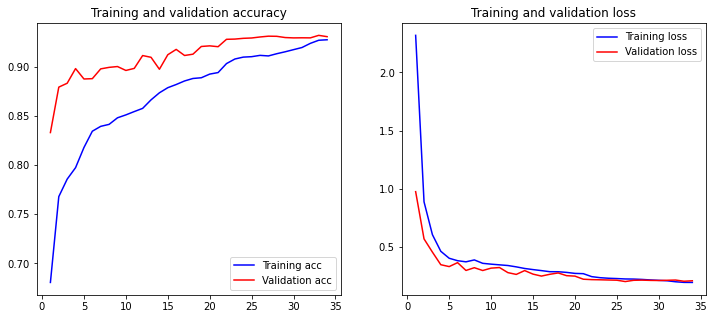

In [13]:
plot_history(history2)

In [34]:
# model_ProtCNN.save("/mnt/vdb/ProtCNN.bestmodel.h5")
model_ProtCNN= keras.models.load_model("/mnt/vdb/ProtCNN.hdf5")

In [14]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     21596
           1       0.94      0.91      0.93     21260

    accuracy                           0.93     42856
   macro avg       0.93      0.93      0.93     42856
weighted avg       0.93      0.93      0.93     42856



In [19]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     25564
           1       0.94      0.95      0.95     25244

    accuracy                           0.95     50808
   macro avg       0.95      0.95      0.95     50808
weighted avg       0.95      0.95      0.95     50808



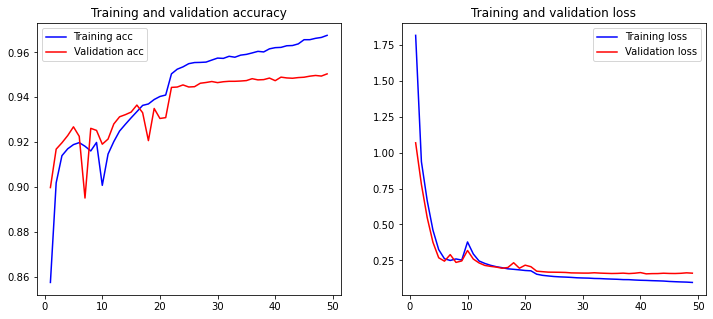

In [20]:
plot_history(history2)

In [3]:
display_model_score(model_ProtCNN,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

NameError: name 'model_ProtCNN' is not defined

# Conclusion

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
with tf.device('/cpu:0'):
        ProtCNN= load_model("/mnt/vdb/ProtCNN.bestmodel.h5")
ProtCNN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1900, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1900, 256)    512         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1900, 256)    1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1900, 256)    0           batch_normalization[0][0]        
_______________________________________________________________________________________